In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from typing import Union
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
sales = pd.read_csv("sales_train_evaluation.csv")
price = pd.read_csv("sell_prices.csv")
cal = pd.read_csv("calendar.csv")

In [4]:
data = pd.read_pickle("data.pkl")
data

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,wm_yr_wk,wday,...,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,lag_28,rolling_mean_10,rolling_mean_20,rolling_mean_30
30490000,14370,1437,3,1,0,0,1001,2,11339,7,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.300049,0.399902,0.433350
30490001,14380,1438,3,1,0,0,1001,0,11339,7,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.000000,0.099976,0.199951
30490002,14390,1439,3,1,0,0,1001,0,11339,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
30490003,14400,1440,3,1,0,0,1001,0,11339,7,...,2.0,1.0,2.0,1.0,0.0,3.0,0.0,1.700195,1.700195,1.799805
30490004,14410,1441,3,1,0,0,1001,1,11339,7,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.000000,1.049805,1.033203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,14329,1432,2,0,9,2,1969,0,11621,2,...,0.0,0.0,1.0,3.0,1.0,0.0,1.0,0.799805,0.700195,0.633301
60034806,14339,1433,2,0,9,2,1969,0,11621,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.199951,0.250000,0.300049
60034807,14349,1434,2,0,9,2,1969,0,11621,2,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.700195,0.799805,0.766602
60034808,14359,1435,2,0,9,2,1969,0,11621,2,...,1.0,1.0,6.0,1.0,1.0,0.0,3.0,1.599609,1.349609,1.366211


In [5]:
#Data Distribution

X_train = data[data['d']<1914]
X_val = data[(data['d']>=1914) & (data['d']<=1941)]
X_test = data[(data['d']>=1942)]

y_train = X_train['sales']
y_val = X_val['sales']

X_train.drop(['id', 'd','sales', 'wm_yr_wk'],axis = 1,inplace = True)
X_val.drop(['id', 'd','sales', 'wm_yr_wk'],axis = 1,inplace = True)
X_test.drop(['id', 'd','sales', 'wm_yr_wk'],axis = 1,inplace = True)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape)

(27837370, 27) (27837370,)
(853720, 27) (853720,)
(853720, 27)


In [6]:
del data

In [10]:
#Performance metric 

#https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 0  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            all_scores.append(lv_scores.sum())

        return np.mean(all_scores)

### 1. XGBRegressor

In [38]:
#Hyeperparameter tuning
#Manually tuning learning_rate and max_depth

lr = [0.01, 0.05, 0.1]
md = [3, 5, 7]

for i in lr:
    for j in md:
        xgb_ht = XGBRegressor(objective = 'reg:tweedie', learning_rate = i, max_depth = j, subsample = 0.7, 
                              colsample_bytree = 0.7, n_estimators = 100) 
        
        xgb_ht.fit(X_train,y_train)
        y_pred = xgb_ht.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred) ** 0.5
        print("*" * 50)
        print(f"For learning_rate = {i} and max_depth = {j}, the rmse = {rmse}")
        print("*" * 50)

[09:34:31] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
**************************************************
For learning_rate = 0.01 and max_depth = 3, the rmse = 3.385595150668632
**************************************************
[09:52:04] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
**************************************************
For learning_rate = 0.01 and max_depth = 5, the rmse = 3.375249500235912
**************************************************
[10:16:54] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
***********************

In [21]:
xgb = XGBRegressor(objective = 'reg:tweedie', learning_rate = 0.1, max_depth = 7, subsample = 0.7, 
                   colsample_bytree = 0.7, n_estimators = 100)

xgb.fit(X_train,y_train, eval_set=[(X_val,y_val)], eval_metric='rmse', verbose=10)

[17:29:50] WARNING: ../src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:3.73523
[10]	validation_0-rmse:3.31419
[20]	validation_0-rmse:2.60715
[30]	validation_0-rmse:2.06575
[40]	validation_0-rmse:1.88274
[50]	validation_0-rmse:1.83754
[60]	validation_0-rmse:1.82432
[70]	validation_0-rmse:1.81604
[80]	validation_0-rmse:1.80985
[90]	validation_0-rmse:1.80529
[99]	validation_0-rmse:1.80062


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:tweedie', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=None, subsample=0.7, tree_method='approx',
             validate_parameters=1, verbosity=None)

In [9]:
import pickle
pickle.dump(xgb,open('xgb.pkl','wb'))

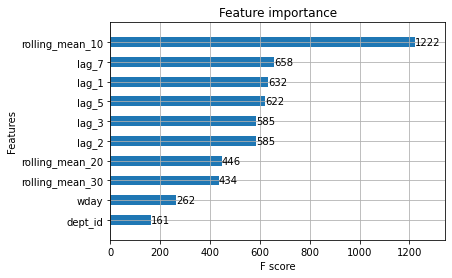

In [10]:
from xgboost import plot_importance

plot_importance(xgb,max_num_features = 10, height = 0.5)
plt.show()

In [22]:
pred_val_array  = xgb.predict(X_val)
pred_test_array  = xgb.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [23]:
d_cols = [d for d in sales.columns if 'd_' in d][-28:]
preds_val = pd.DataFrame(pred_val_array,columns = d_cols)
train_df = sales.iloc[:,:-28]
val_df = sales.iloc[:,-28:]
evaluator = WRMSSEEvaluator(train_df, val_df, cal, price)
score = evaluator.score(preds_val)
print("WRMSSE score of validation data [for days 1914-1941]:",score)

100%|██████████| 12/12 [00:17<00:00,  1.48s/it]


WRMSSE score of validation data [for days 1914-1941]: 0.5455359570607516


In [26]:
sub_df = pd.read_csv("sample_submission.csv")
sub_1 = sub_df.iloc[:30490,:]
sub_2 = sub_df.iloc[30490:,:]
f_cols = sub_df.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.233210,5.153933e-01,9.353096e-01,7.051138e-01,8.887784e-01,1.301920,1.239235,1.122800,0.568396,...,1.308356,1.992122,1.281998,0.844782,0.814991,1.042148,1.092349,1.417210,0.898343,1.409715
1,HOBBIES_1_002_CA_1_validation,0.000164,4.007977e-01,2.869719e-02,2.126299e-01,1.751912e-01,0.232749,0.003344,0.207906,0.001581,...,0.187201,0.222788,0.450943,0.230986,0.239885,0.214591,0.296342,0.317700,0.575720,0.352027
2,HOBBIES_1_003_CA_1_validation,0.722096,8.135951e-01,6.727012e-01,9.172167e-01,4.515186e-01,0.812279,0.888189,0.593877,0.377772,...,0.534720,1.113739,1.271171,0.659587,0.809307,0.143942,1.001022,0.785186,0.863541,0.626374
3,HOBBIES_1_004_CA_1_validation,1.447353,1.641907e+00,2.007216e+00,1.425705e+00,2.311493e+00,2.052781,2.997042,2.629827,1.674856,...,1.235415,2.008857,1.922322,1.955004,1.290224,0.855462,0.988943,1.410684,1.290163,2.866711
4,HOBBIES_1_005_CA_1_validation,0.988706,8.174994e-01,1.161937e+00,1.798355e+00,1.475580e+00,1.655070,1.961260,1.822833,1.851764,...,1.503728,1.914705,1.747241,1.554834,1.356572,1.046775,0.774340,1.506789,1.034707,0.674981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.181816,4.803734e-02,1.715601e-01,4.792241e-01,5.536843e-01,0.618649,0.228658,0.525420,0.790246,...,0.395344,0.492797,1.283268,0.423747,0.613221,0.334458,0.874239,0.364972,1.206793,0.702471
60976,FOODS_3_824_WI_3_evaluation,0.001743,1.507947e-01,3.992793e-01,2.030828e-01,2.461295e-01,0.229495,0.409226,0.584875,0.306977,...,0.391986,0.457673,0.000003,0.000002,0.000002,0.000002,0.153350,0.003572,0.215523,0.024791
60977,FOODS_3_825_WI_3_evaluation,0.294252,5.358575e-01,5.808750e-01,3.704543e-01,4.293353e-01,0.446938,0.652347,0.637637,0.350592,...,0.507117,0.995038,0.899206,1.250356,0.827674,0.824748,1.036450,1.245853,0.504360,0.946608
60978,FOODS_3_826_WI_3_evaluation,0.605249,1.300572e+00,5.817778e-01,1.226895e+00,1.062801e+00,1.845601,1.385970,1.709693,1.441409,...,1.294291,1.137806,1.423934,1.302064,1.638922,0.893325,0.927883,1.546390,1.984854,1.461359


In [27]:
sub.to_csv("xgb_sub.csv",index = False)

<b>private & public leaderboard scores</b>
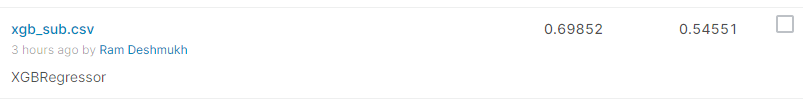

### 2. CatBoostRegressor

In [27]:
#Hyeperparameter tuning
#Manually tuning learning_rate and max_depth

lr = [0.01, 0.05, 0.1]
md = [3, 5, 7]
cat_features = ['item_id','store_id','state_id','dept_id','cat_id','event_name_1','event_type_1','event_name_2','event_type_2']

for i in lr:
    for j in md:
        cgb_ht = CatBoostRegressor(learning_rate = i, depth = j, rsm = 0.7, iterations = 100, cat_features = cat_features) 
        cgb_ht.fit(X_train,y_train,verbose = False)
        y_pred = cgb_ht.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred) ** 0.5
        print("*" * 50)
        print(f"For learning_rate = {i} and max_depth = {j}, the rmse = {rmse}")
        print("*" * 50)

**************************************************
For learning_rate = 0.01 and max_depth = 3, the rmse = 2.4374210961367955
**************************************************
**************************************************
For learning_rate = 0.01 and max_depth = 5, the rmse = 2.3543389754199264
**************************************************
**************************************************
For learning_rate = 0.01 and max_depth = 7, the rmse = 2.308169432162276
**************************************************
**************************************************
For learning_rate = 0.05 and max_depth = 3, the rmse = 1.952873971838326
**************************************************
**************************************************
For learning_rate = 0.05 and max_depth = 5, the rmse = 1.9171269062122238
**************************************************
**************************************************
For learning_rate = 0.05 and max_depth = 7, the rmse = 1.89004331993978

In [28]:
cat_features = ['item_id','store_id','state_id','dept_id','cat_id','event_name_1','event_type_1','event_name_2','event_type_2']

cgb = CatBoostRegressor(learning_rate = 0.05, depth = 5, rsm = 0.7, iterations = 100, cat_features = cat_features) 

cgb.fit(X_train,y_train, eval_set=[(X_val,y_val)], verbose=10)

0:	learn: 3.5345284	test: 3.5289676	best: 3.5289676 (0)	total: 6.51s	remaining: 10m 44s
10:	learn: 2.7240946	test: 2.6735854	best: 2.6735854 (10)	total: 40.6s	remaining: 5m 28s
20:	learn: 2.3171855	test: 2.2447541	best: 2.2447541 (20)	total: 1m 10s	remaining: 4m 25s
30:	learn: 2.1205579	test: 2.0375488	best: 2.0375488 (30)	total: 1m 40s	remaining: 3m 44s
40:	learn: 2.0262581	test: 1.9400436	best: 1.9400436 (40)	total: 2m 10s	remaining: 3m 8s
50:	learn: 1.9803973	test: 1.8963467	best: 1.8963467 (50)	total: 2m 41s	remaining: 2m 35s
60:	learn: 1.9556704	test: 1.8748668	best: 1.8748668 (60)	total: 3m 12s	remaining: 2m 2s
70:	learn: 1.9409540	test: 1.8629593	best: 1.8629593 (70)	total: 3m 42s	remaining: 1m 30s
80:	learn: 1.9304667	test: 1.8550438	best: 1.8550438 (80)	total: 4m 13s	remaining: 59.5s
90:	learn: 1.9224166	test: 1.8494959	best: 1.8494959 (90)	total: 4m 44s	remaining: 28.1s
99:	learn: 1.9162691	test: 1.8457141	best: 1.8457141 (99)	total: 5m 12s	remaining: 0us

bestTest = 1.845714

In [86]:
import pickle
pickle.dump(cgb,open('cgb.pkl','wb'))

Text(0.5, 0, 'Importance')

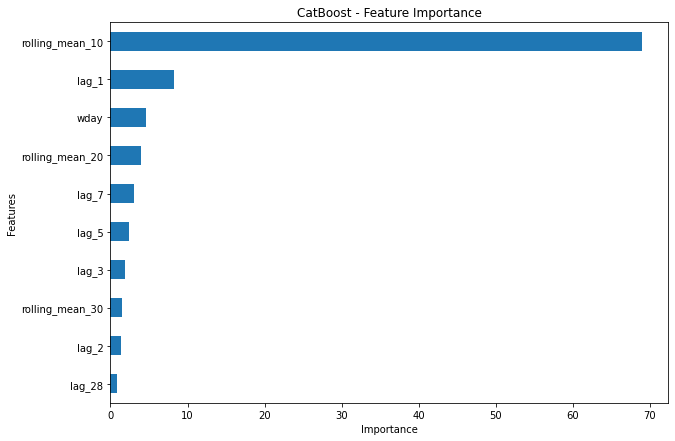

In [30]:
fea_imp = pd.DataFrame({'imp': cgb.feature_importances_, 'col': X_train.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-10:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance')

In [29]:
pred_val_array  = cgb.predict(X_val)
pred_test_array  = cgb.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [30]:
preds_val = pd.DataFrame(pred_val_array,columns = d_cols)
train_df = sales.iloc[:,:-28]
val_df = sales.iloc[:,-28:]
evaluator = WRMSSEEvaluator(train_df, val_df, cal, price)
score = evaluator.score(preds_val)
print("WRMSSE score of validation data [for days 1914-1941]:",score)

100%|██████████| 12/12 [00:16<00:00,  1.39s/it]


WRMSSE score of validation data [for days 1914-1941]: 0.6709644172773804


In [31]:
sub_1 = sub_df.iloc[:30490,:]
sub_2 = sub_df.iloc[30490:,:]
f_cols = sub_df.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.957282,0.695955,0.736388,0.737303,0.842865,1.071476,1.365303,1.257135,0.964187,...,1.063710,1.687414,1.691467,1.268770,1.087965,0.880204,1.114687,1.275389,1.405430,1.309474
1,HOBBIES_1_002_CA_1_validation,0.097213,0.177131,0.258970,0.177131,0.194347,0.139541,0.139622,0.104511,0.114698,...,0.105729,0.143695,0.430751,0.432645,0.485014,0.478797,0.396488,0.405967,0.504994,0.482356
2,HOBBIES_1_003_CA_1_validation,0.771503,0.678215,0.567093,0.721484,0.638304,0.817163,1.012959,0.743072,0.578244,...,0.647751,0.952263,1.012771,0.763204,0.592529,0.349171,0.513040,0.873237,0.976953,0.945476
3,HOBBIES_1_004_CA_1_validation,2.089079,1.858860,1.634634,1.523787,1.897457,2.457326,2.822344,2.646410,1.990420,...,1.423697,1.764964,1.750889,1.485380,1.499357,1.120857,1.242056,1.331975,1.388355,2.125033
4,HOBBIES_1_005_CA_1_validation,1.383233,1.271296,1.181565,1.615859,1.647768,1.814821,1.867847,1.667026,1.759226,...,1.662536,1.766697,1.686462,1.305178,1.388919,1.114912,0.902033,0.965170,1.159280,0.937118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.282187,0.183027,0.196000,0.355063,0.577629,0.730398,0.527012,0.440769,0.558908,...,0.448052,0.690234,0.855992,0.675151,0.599644,0.609851,0.669702,0.554966,0.759133,0.920398
60976,FOODS_3_824_WI_3_evaluation,0.117887,0.200631,0.347369,0.421530,0.429342,0.424982,0.412951,0.341365,0.325358,...,0.206469,0.258021,0.144689,0.093663,0.098294,0.080653,0.117887,0.202081,0.253867,0.351506
60977,FOODS_3_825_WI_3_evaluation,0.482807,0.397887,0.524757,0.519224,0.497916,0.601671,0.766421,0.687770,0.596944,...,0.805821,0.900876,0.934301,0.997765,0.948147,0.883417,0.962389,0.808132,0.740337,0.817884
60978,FOODS_3_826_WI_3_evaluation,0.918467,1.161838,0.997623,1.059764,1.224601,1.557000,1.492332,1.211485,1.249615,...,1.085464,1.197768,1.161210,1.288830,1.754692,1.546817,1.399440,1.602239,1.819976,1.693486


In [32]:
sub.to_csv("cgb_sub.csv",index = False)

<b>Private and Public leaderboard scores</b>
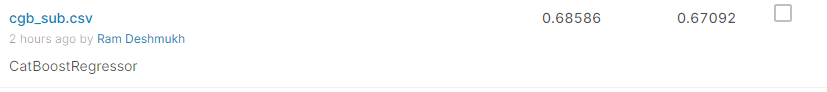

### 3. LGBMRegressor

In [85]:
lr = [0.05, 0.1]
md = [3, 5, 7]

for i in lr:
    for j in md:
        lgb_ht = LGBMRegressor(objective = 'tweedie', learning_rate = i, max_depth = j ,subsample = 0.7, 
                              colsample_bytree = 0.7, n_estimators = 100) 
        lgb_ht.fit(X_train,y_train, verbose = False)
        y_pred = lgb_ht.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred) ** 0.5
        print("*" * 50)
        print(f"For learning_rate = {i} and max_depth = {j}, the rmse = {rmse}")
        print("*" * 50)

**************************************************
For learning_rate = 0.05 and max_depth = 3, the rmse = 2.1081802768999958
**************************************************
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
**************************************************
For learning_rate = 0.05 and max_depth = 5, the rmse = 1.9699432391101857
**************************************************
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
**************************************************
For learning_rate = 0.05 and max_depth = 7, the rmse = 1.950333253660376
**************************************************
**************************************************
For learning_rate = 0.1 and max_depth = 3, the rmse = 2.002958088186279
**************************************************
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_

In [78]:
lgb = LGBMRegressor(objective = 'tweedie', learning_rate = 0.1, max_depth = 7,num_leaves = 20,n_estimators = 100)

lgb.fit(X_train,y_train,categorical_feature = cat_features , eval_set=[(X_train,y_train),(X_val,y_val)], eval_metric='rmse', verbose=10)

[10]	training's rmse: 3.09226	training's tweedie: 3.45696	valid_1's rmse: 3.05838	valid_1's tweedie: 3.96995
[20]	training's rmse: 2.52606	training's tweedie: 3.20695	valid_1's rmse: 2.43756	valid_1's tweedie: 3.77602
[30]	training's rmse: 2.18856	training's tweedie: 3.12819	valid_1's rmse: 2.07811	valid_1's tweedie: 3.72093
[40]	training's rmse: 2.05904	training's tweedie: 3.0974	valid_1's rmse: 1.94866	valid_1's tweedie: 3.69965
[50]	training's rmse: 2.01326	training's tweedie: 3.08281	valid_1's rmse: 1.90616	valid_1's tweedie: 3.68858
[60]	training's rmse: 1.97873	training's tweedie: 3.07332	valid_1's rmse: 1.877	valid_1's tweedie: 3.67997
[70]	training's rmse: 1.96431	training's tweedie: 3.06657	valid_1's rmse: 1.86548	valid_1's tweedie: 3.67304
[80]	training's rmse: 1.94538	training's tweedie: 3.06156	valid_1's rmse: 1.85052	valid_1's tweedie: 3.6677
[90]	training's rmse: 1.93424	training's tweedie: 3.05712	valid_1's rmse: 1.84125	valid_1's tweedie: 3.66272
[100]	training's rmse: 

LGBMRegressor(max_depth=7, num_leaves=15, objective='tweedie')

In [20]:
import pickle
pickle.dump(lgb,open('lgb.pkl','wb'))

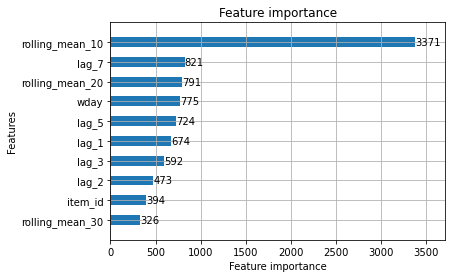

In [83]:
from lightgbm import plot_importance

plot_importance(lgb,max_num_features = 10, height = 0.5)
plt.show()

In [79]:
pred_val_array  = lgb.predict(X_val)
pred_test_array  = lgb.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [80]:
d_cols = [d for d in sales.columns if 'd_' in d][-28:]
preds_val = pd.DataFrame(pred_val_array,columns = d_cols)
train_df = sales.iloc[:,:-28]
val_df = sales.iloc[:,-28:]
evaluator = WRMSSEEvaluator(train_df, val_df, cal, price)
score = evaluator.score(preds_val)
print("WRMSSE score of validation data [for days 1914-1941]:",score)

100%|██████████| 12/12 [00:18<00:00,  1.55s/it]


WRMSSE score of validation data [for days 1914-1941]: 0.5865258210963394


In [81]:
sub_df = pd.read_csv("sample_submission.csv")
sub_1 = sub_df.iloc[:30490,:]
sub_2 = sub_df.iloc[30490:,:]
f_cols = sub_df.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.246212e+00,4.911067e-01,9.152646e-01,6.465302e-01,9.298052e-01,1.291979,1.239641,1.251319,0.612912,...,1.255975,1.864108,1.409085e+00,8.971317e-01,8.239112e-01,1.128110e+00,0.984126,1.485313,1.084389,1.421078
1,HOBBIES_1_002_CA_1_validation,1.125691e-03,3.894238e-01,4.519472e-02,1.780686e-01,1.752771e-01,0.238764,0.001982,0.206619,0.001118,...,0.213836,0.233283,4.723774e-01,2.715035e-01,2.642313e-01,2.954444e-01,0.329756,0.342078,0.580087,0.376405
2,HOBBIES_1_003_CA_1_validation,7.399116e-01,7.786267e-01,6.230055e-01,8.844286e-01,4.012436e-01,0.811515,0.860354,0.578255,0.382457,...,0.543302,1.069680,1.145101e+00,6.651684e-01,8.089922e-01,1.510293e-01,1.097971,0.782572,0.967433,0.692493
3,HOBBIES_1_004_CA_1_validation,1.720369e+00,1.852619e+00,1.919121e+00,1.336251e+00,2.084716e+00,2.481215,3.048357,2.723822,1.791787,...,1.157176,1.853570,1.880882e+00,1.764733e+00,1.368813e+00,8.779084e-01,0.986738,1.334504,1.158266,2.614072
4,HOBBIES_1_005_CA_1_validation,1.124902e+00,9.212145e-01,1.113246e+00,1.750980e+00,1.615130e+00,1.787108,2.066622,1.767884,1.878998,...,1.552890,1.887462,1.779744e+00,1.480259e+00,1.314346e+00,1.024555e+00,0.687611,1.360812,0.874046,0.499484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,1.872745e-01,4.678467e-02,1.527847e-01,4.631136e-01,5.314111e-01,0.643472,0.262016,0.481189,0.804810,...,0.359352,0.452748,1.158642e+00,3.974147e-01,6.589526e-01,3.748417e-01,0.981456,0.398814,1.203616,0.661936
60976,FOODS_3_824_WI_3_evaluation,1.092441e-03,1.527847e-01,3.958898e-01,1.958071e-01,2.364957e-01,0.273239,0.394662,0.547319,0.349388,...,0.415617,0.439773,6.326001e-08,6.151474e-08,6.151474e-08,6.151474e-08,0.197168,0.001461,0.198997,0.062663
60977,FOODS_3_825_WI_3_evaluation,2.361256e-01,5.056543e-01,6.305720e-01,3.274625e-01,4.067834e-01,0.455425,0.698323,0.646545,0.332921,...,0.569288,1.022792,8.354548e-01,1.069042e+00,7.947040e-01,8.430717e-01,1.106707,1.203890,0.515454,0.943808
60978,FOODS_3_826_WI_3_evaluation,5.796532e-01,1.386213e+00,6.543344e-01,1.142176e+00,1.252025e+00,2.091558,1.576338,1.680709,1.419073,...,1.269936,1.086966,1.325401e+00,1.318265e+00,1.941445e+00,1.190311e+00,1.076312,1.371940,1.890603,1.552098


In [82]:
sub.to_csv("lgb_sub.csv",index = False)

In [75]:
sub_val

,item_id,dept_id,cat_id,store_id,state_id,wday,month,year,event_name_1,event_type_1,...,lag_2,lag_3,lag_5,lag_7,lag_14,lag_21,lag_28,rolling_mean_10,rolling_mean_20,rolling_mean_30
58327370,1437,3,1,0,0,3,4,2016,-1,-1,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.099609,1.049805,0.933105
58327371,1438,3,1,0,0,3,4,2016,-1,-1,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.099976,0.049988,0.099976
58327372,1439,3,1,0,0,3,4,2016,-1,-1,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.899902,0.750000,0.533203
58327373,1440,3,1,0,0,3,4,2016,-1,-1,...,7.0,3.0,0.0,4.0,2.0,1.0,0.0,2.300781,2.050781,1.900391
58327374,1441,3,1,0,0,3,4,2016,-1,-1,...,2.0,2.0,1.0,0.0,2.0,0.0,1.0,1.500000,1.200195,1.299805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59181085,1432,2,0,9,2,2,5,2016,-1,-1,...,0.0,0.0,1.0,3.0,1.0,0.0,1.0,0.799805,0.700195,0.633301
59181086,1433,2,0,9,2,2,5,2016,-1,-1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.199951,0.250000,0.300049
59181087,1434,2,0,9,2,2,5,2016,-1,-1,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.700195,0.799805,0.766602
59181088,1435,2,0,9,2,2,5,2016,-1,-1,...,1.0,1.0,6.0,1.0,1.0,0.0,3.0,1.599609,1.349609,1.366211


<b>Private and public leaderboard scores</b>
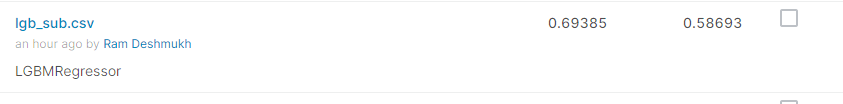

In [84]:
##final results
from prettytable import PrettyTable

p = PrettyTable(["Model","Public lb score","Private lb score"])
p.add_row(['XGBoostRegrssor','0.698','0.545'])
p.add_row(['CatBoostRegrssor','0.685','0.670'])
p.add_row(['LGBMRegrssor','0.693','0.586'])
print(p)

+------------------+-----------------+------------------+
|      Model       | Public lb score | Private lb score |
+------------------+-----------------+------------------+
| XGBoostRegrssor  |      0.698      |      0.545       |
| CatBoostRegrssor |      0.685      |      0.670       |
|   LGBMRegrssor   |      0.693      |      0.586       |
+------------------+-----------------+------------------+


<b>CatBoostRegressor performed well than other</b>